<a href="https://colab.research.google.com/github/rojinadeuja/NLP-Model-Implementations/blob/master/GloVe_using_Gensim_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np
GLOVE_DIR = '/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt'
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/IMDB.csv'

df = pd.read_csv(DATA_DIR)
df.replace(['positive', 'negative'], [1, 0], inplace=True)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Data pre-processing

data = list(df.review)
labels = list(df.sentiment)

tokenizer = Tokenizer(num_words=10000) # Only 10000 most met words
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)

In [8]:
data = pad_sequences(sequences, maxlen=100) # Only 100 words in one review
labels = np.array(labels)

train_data = data[:30000]
train_labels = labels[:30000]

validation_data = data[30000:40000]
validation_labels = labels[30000:40000]

test_data = data[40000:]
test_labels = labels[40000:]

In [11]:
embedding_index = {}
with open(GLOVE_DIR) as file: # Preparing glove
    for line in file:
        values = line.split()
        key = values[0]
        value = values[1:]
        embedding_index[key] = np.array(value, dtype='float32')
        
        
embedding_matrix = np.zeros((10000, 100)) # 10000 - num_words, 100 - length of sequence
for word, i in tokenizer.word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [12]:
import tensorflow as tf
from tensorflow.keras import losses, optimizers
from tensorflow.keras.layers import Dense, Embedding, Flatten

model = tf.keras.models.Sequential([
    Embedding(10000, 100, input_length=100),
    Flatten(),
    Dense(32, activation=tf.nn.relu),
    Dense(1, activation=tf.nn.sigmoid),
])

model.layers[0].set_weights([embedding_matrix]) # Add glove to our model
model.layers[0].trainable = False # Freeze embedding layer

model.compile(
    loss = losses.binary_crossentropy,
    optimizer = optimizers.RMSprop(lr=0.001),
    metrics = ['accuracy'],
)

history = model.fit(
    train_data, train_labels,
    validation_data = [validation_data, validation_labels],
    batch_size = 32, 
    epochs = 10,
)

Epoch 1/10
938/938 [==============================] - 6s 7ms/step - loss: 0.6142 - accuracy: 0.6642 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.5095 - accuracy: 0.7500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4617 - accuracy: 0.7806 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4250 - accuracy: 0.8003 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3870 - accuracy: 0.8228 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3479 - accuracy: 0.8439 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3044 - accuracy: 0.8619 

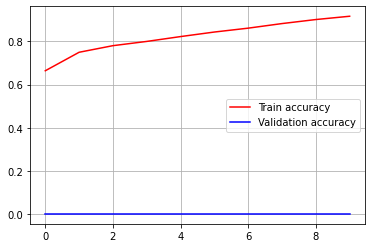

Test accuracy:  72.43 %


In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], 'r-', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'b-', label='Validation accuracy')
plt.legend()
plt.grid()
plt.show()

_, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print('Test accuracy: ', round(accuracy * 100, 2), '%')